In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

features = 16
# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=512)
        self.enc2 = nn.Linear(in_features=512, out_features=features*2)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=features, out_features=512)
        self.dec2 = nn.Linear(in_features=512, out_features=784)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size - return standard normal distribution
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        print(x.shape)
        x = self.enc2(x).view(-1, 2, features)
        print(x.shape)

        # get `mu` and `log_var`
        # mu: mean of encoded latent space
        # sigma: log variance of encoding space

        # this is just a toy example
        # since mu and log_var should come from different distributions
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var


vae = LinearVAE()
from torchinfo import summary
summary(vae, input_size=(1, 784))

torch.Size([1, 512])
torch.Size([1, 2, 16])


Layer (type:depth-idx)                   Output Shape              Param #
LinearVAE                                [1, 784]                  --
├─Linear: 1-1                            [1, 512]                  401,920
├─Linear: 1-2                            [1, 32]                   16,416
├─Linear: 1-3                            [1, 512]                  8,704
├─Linear: 1-4                            [1, 784]                  402,192
Total params: 829,232
Trainable params: 829,232
Non-trainable params: 0
Total mult-adds (M): 0.83
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 3.32
Estimated Total Size (MB): 3.33

#### Reparameterization trick

The goal is to sample from encoded distribution $(\mu,\sigma)$, where $log(\sigma^2)$ = log_var. $\sigma$ = $e^{\frac{1}{2}a}$

$x \sim N(\mu,\sigma)$ = $\mu + \sigma * noise $, where $noise \sim N(0,I)$

In [3]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

#### KL diivergence

measure distance between $N(\mu,\sigma)$ and $N(0,I)$

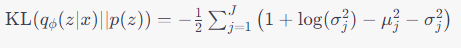